<a href="https://colab.research.google.com/github/siddhi5386/Emotion-Recognition-from-brain-EEG-signals-/blob/master/Emotion_recognition_from_brain_signals_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-hgte5n81
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-hgte5n81
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=a57a66954f4fa0158eaf906cff5ee04408b9c00fbeb8dbc3f3156b67fcf60f02
  Stored in directory: /tmp/pip-ephem-wheel-cache-kl4orrwd/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [2]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')

In [4]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [5]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/My Drive/leading_ai/try/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/leading_ai/try/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [6]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [7]:

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/leading_ai/try/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/leading_ai/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/leading_ai/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 70) (46848, 4)
testing dataset: (11712, 70) (11712, 4)


In [73]:

with open('/content/drive/My Drive/leading_ai/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [74]:
X.shape

(46848, 70)

In [75]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [76]:
y_train.shape

(46848, 10)

In [77]:
x_train = np.array(X[:])

In [78]:

with open('/content/drive/My Drive/leading_ai/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [79]:
x_test = np.array(M[:])

In [80]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [81]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [83]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [84]:
x_train.shape

(46848, 70, 1)

In [85]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [86]:
print(input_shape)

(70, 1)


In [87]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [88]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 70, 128)           512       
_________________________________________________________________
batch_normalization_6 (Batch (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_7 (Batch (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 17, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 17, 64)           

In [89]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [90]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
183/183 [==============================] - 2s 10ms/step - loss: 1.6859 - accuracy: 0.3247 - val_loss: 1.8223 - val_accuracy: 0.2357
Epoch 2/200
183/183 [==============================] - 2s 9ms/step - loss: 1.4895 - accuracy: 0.3931 - val_loss: 1.4592 - val_accuracy: 0.3817
Epoch 3/200
183/183 [==============================] - 2s 9ms/step - loss: 1.3964 - accuracy: 0.4376 - val_loss: 1.2789 - val_accuracy: 0.4924
Epoch 4/200
183/183 [==============================] - 2s 9ms/step - loss: 1.3185 - accuracy: 0.4723 - val_loss: 1.1832 - val_accuracy: 0.5314
Epoch 5/200
183/183 [==============================] - 2s 9ms/step - loss: 1.2495 - accuracy: 0.5021 - val_loss: 1.1358 - val_accuracy: 0.5451
Epoch 6/200
183/183 [==============================] - 2s 9ms/step - loss: 1.1834 - accuracy: 0.5331 - val_loss: 1.0372 - val_accuracy: 0.5891
Epoch 7/200
183/183 [==============================] - 2s 9ms/step - loss: 1.1223 - accuracy: 0.5544 - val_loss: 0.9838 - val_accuracy: 0.607

In [91]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

366/366 [==============================] - 1s 3ms/step - loss: 0.4598 - accuracy: 0.8772
Test loss: 0.45984095335006714
Test accuracy: 0.8772199749946594


In [92]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


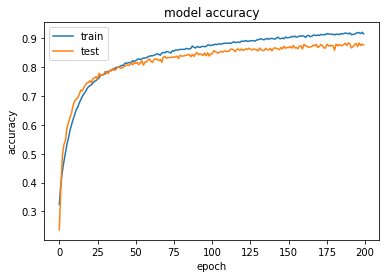

In [93]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

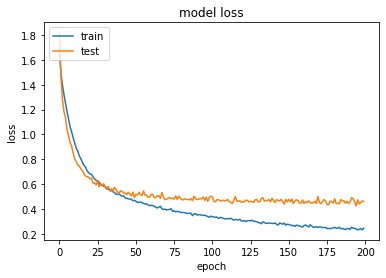

In [94]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

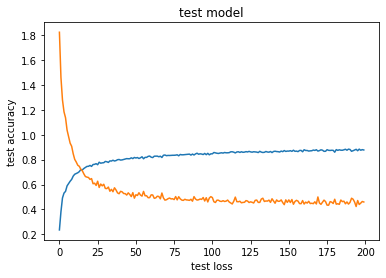

In [95]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [96]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

In [97]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [98]:
y_pred[1]

array([4.7614737e-38, 3.1183075e-07, 0.0000000e+00, 4.4039957e-08,
       1.4481380e-11, 2.0261881e-05, 9.3925128e-06, 9.9996865e-01,
       5.1518407e-07, 8.2126684e-07], dtype=float32)

In [99]:
y_test1=np.argmax(y_test, axis=1)

In [100]:
y_pred=np.argmax(y_pred,axis=1)

In [101]:
y_test1[1]

7

In [102]:
y_pred[1]

7

In [103]:
cmatrix=confusion_matrix(y_test1, y_pred)

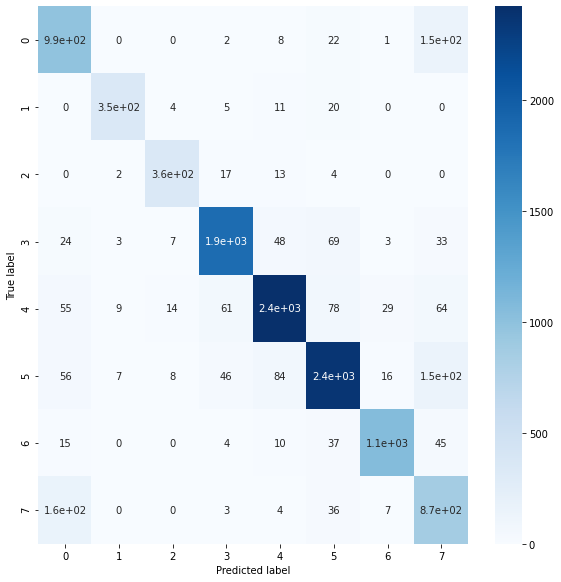

In [104]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()